<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Definicja modelu

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [18,18,18]).to(device)

summary(model, (3, 32, 32))

# x = torch.randn(1,3,32, 32)
# y = model(x)

# make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 16, 16, 16]           2,320
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
    ResidualBlock-11           [-1, 16, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           2,320
      BatchNorm2d-13           [-1, 16, 16, 16]              32
             ReLU-14           [-1, 16,

In [ ]:
# Hyper-parameters
num_epochs = 100
learning_rate = 0.001
weight_decay = 0.0001
momentum = 0.9

In [ ]:
# Loading the model

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
state = torch.load('content/resnet_cifar10_219.pth', map_location=torch.device('cpu'))
model = ResNet(ResidualBlock, [18,18,18]).to(device)
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()

print('Acc:', state['accuracy'], '\tLoss: ', state['loss'], '\tAcc test: ', state['test_accuracy'])

Acc: 0.95048 	Loss:  0.13424459638078803 	Acc test:  0.8391


##Trening PCA

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_ftex = models.resnet152(pretrained=True)
modules=list(model_ftex.children())[:-2]
print(list(model_ftex.children()))
print(modules)
print(len(modules))
model_ftex=nn.Sequential(*modules).to(device)

model_ftex.eval()


normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])
batch_size = 128

train_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=True, transform=transforms.Compose([
            # transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

counter = 0
features = []
labels = []
with torch.no_grad():
    for (inputs, targets) in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model_ftex(inputs).to(device)
      for i in range(len(outputs)):
        output = torch.flatten(outputs[i], start_dim=1)
        features.append(output.to('cpu'))
      print('Batch ', counter, '/', len(train_loader))
      counter = counter + 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

features_np = [x.numpy() for x in features]
features_np = np.array(features_np)
# flatten
print(features_np.shape)
# features_np = features_np.reshape(-1, features_np.shape[1] * features_np.shape[2] * features_np.shape[3])
features_np = features_np.reshape(-1, features_np.shape[1] * features_np.shape[2])
print(features_np.shape)
labels_np = np.array([y.squeeze().numpy() for y in labels])
print(labels_np)

features_col = ['Feature' + str(i) for i in range(features_np.shape[1])]
df_cifar = pd.DataFrame(features_np, columns = features_col)
df_cifar['Label'] = labels_np
print(df_cifar.head())


(50000, 2048, 1)
(50000, 2048)
[2 9 2 ... 1 0 7]
   Feature0  Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
0  0.000000  0.000000  0.000000  0.722756  0.278020  1.289663  1.064759   
1  2.695035  0.914895  0.000000  0.000000  0.000000  0.000000  1.204534   
2  0.000000  0.000000  1.541544  0.071209  0.129672  0.000000  0.000000   
3  2.658777  0.321044  0.000000  0.000000  1.561153  0.000000  0.000000   
4  0.177746  0.000000  0.000000  1.990450  1.359092  0.000000  0.000000   

   Feature7  Feature8  Feature9  ...  Feature2039  Feature2040  Feature2041  \
0  0.343266  0.000000  0.903132  ...     0.112453     1.360410     0.744933   
1  4.284622  0.000000  1.158628  ...     0.660336     1.996987     1.364441   
2  0.000000  0.000000  0.515222  ...     0.000000     0.147604     0.502077   
3  3.389142  0.060294  3.582479  ...     2.570861     0.954547     0.000000   
4  0.000000  0.783884  0.000000  ...     0.200425     0.000000     0.000000   

   Feature2042  Feature20

Przeprowadzono zmniejszenie wymiarowości obrazów w celu porównania otrzymanych dwuwymiarowych wektrów reprezentujących różne klasy obrazów w przestrzeni cech.
Do zmniejszenia wymiarowości użyto metody PCA (*Principal Component Analysis*).

In [12]:
pca_model = PCA(2)
# apply PCA to each column except the last one (label)
convereted_data = pca_model.fit_transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np

print(df_converted_data.head())


   Principal Component 1  Principal Component 2  Label
0               9.336911              -5.013639      2
1               9.870427              -4.265258      9
2              -4.008854               2.776073      2
3               7.562686              -6.215353      9
4              11.363485              -6.671499      5


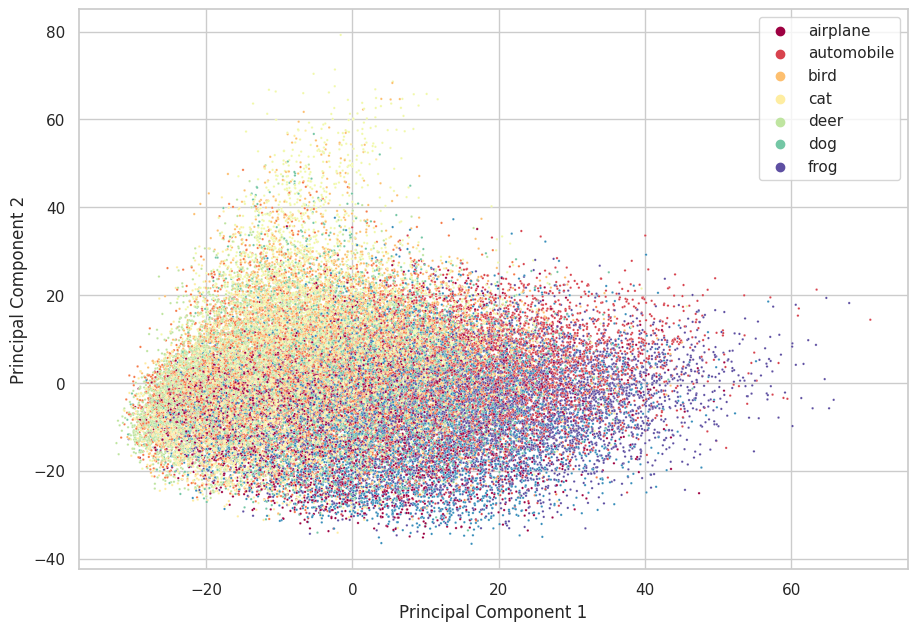

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 3)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')

## Zastosowanie PCA

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# from torchvision.datasets import CIFAR10
# from torchsummary import summary
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# model_ftex = models.resnet152(pretrained=True)
# modules=list(model_ftex.children())[:-2]

# print(len(list(model_ftex.children())))
# print(modules)
# print(len(modules))
# model_ftex=nn.Sequential(*modules).to(device)

# model_ftex.eval()


# normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])
# batch_size = 128

test_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

counter = 0
features = []
labels = []
with torch.no_grad():
    for (inputs, targets) in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model_ftex(inputs).to(device)
      for i in range(len(outputs)):
        output = torch.flatten(outputs[i], start_dim=1)
        features.append(output.to('cpu'))
      print('Batch ', counter, '/', len(train_loader))
      counter = counter + 1

Files already downloaded and verified
Batch  0 / 391
Batch  1 / 391
Batch  2 / 391
Batch  3 / 391
Batch  4 / 391
Batch  5 / 391
Batch  6 / 391
Batch  7 / 391
Batch  8 / 391
Batch  9 / 391
Batch  10 / 391
Batch  11 / 391
Batch  12 / 391
Batch  13 / 391
Batch  14 / 391
Batch  15 / 391
Batch  16 / 391
Batch  17 / 391
Batch  18 / 391
Batch  19 / 391
Batch  20 / 391
Batch  21 / 391
Batch  22 / 391
Batch  23 / 391
Batch  24 / 391
Batch  25 / 391
Batch  26 / 391
Batch  27 / 391
Batch  28 / 391
Batch  29 / 391
Batch  30 / 391
Batch  31 / 391
Batch  32 / 391
Batch  33 / 391
Batch  34 / 391
Batch  35 / 391
Batch  36 / 391
Batch  37 / 391
Batch  38 / 391
Batch  39 / 391
Batch  40 / 391
Batch  41 / 391
Batch  42 / 391
Batch  43 / 391
Batch  44 / 391
Batch  45 / 391
Batch  46 / 391
Batch  47 / 391
Batch  48 / 391
Batch  49 / 391
Batch  50 / 391
Batch  51 / 391
Batch  52 / 391
Batch  53 / 391
Batch  54 / 391
Batch  55 / 391
Batch  56 / 391
Batch  57 / 391
Batch  58 / 391
Batch  59 / 391
Batch  60 / 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns


features_np = [x.squeeze().numpy() for x in features]
features_np = np.array(features_np)
print(features_np.shape)
labels_np = np.array([y.squeeze().numpy() for y in labels])
print(labels_np)

features = ['Feature' + str(i) for i in range(features_np.shape[1])]
df_cifar = pd.DataFrame(features_np, columns = features)
df_cifar['Label'] = labels_np
print(df_cifar.head())


(10000, 2048)
[5 7 5 ... 0 6 2]
   Feature0  Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
0  0.000000  0.000000  3.440967  0.509135  0.000000  0.000000  0.000000   
1  0.000000  0.000000  9.364865  0.000000  1.191369  0.779707  0.121260   
2  0.738118  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  5.987647  2.162060  0.193545  1.419999  0.000000   
4  0.000000  1.226292  5.207107  1.686425  0.000000  0.000000  1.050045   

   Feature7  Feature8  Feature9  ...  Feature2039  Feature2040  Feature2041  \
0  0.415967  0.491710  3.391521  ...     0.381176     0.687183     1.727032   
1  0.000000  2.178581  0.000000  ...     0.524756     0.114713     0.000000   
2  0.000000  0.000000  0.067797  ...     0.000000     0.000000     0.000000   
3  0.269966  7.332595  2.581383  ...     0.181994     0.639963     0.156676   
4  0.000000  0.000000  2.145474  ...     0.240126     3.024080     0.218083   

   Feature2042  Feature2043  Feature2044  

In [ ]:
# apply PCA to each column except the last one (label)
convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np

print(df_converted_data.head())


   Principal Component 1  Principal Component 2  Label
0              35.564236             -15.663911      5
1             -11.572924             -18.554159      7
2             -26.459253              -1.098497      5
3              22.682915             -10.773147      3
4              31.680769             -25.478472      6


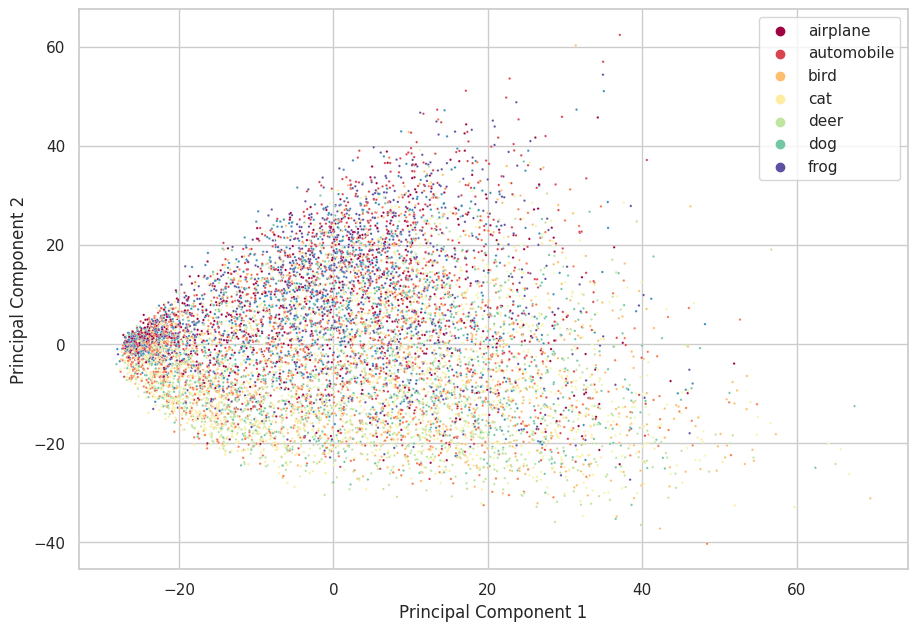

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 3)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')

## Porównanie próbki oryginalnej i adwersarzowej

In [13]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninsta

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified


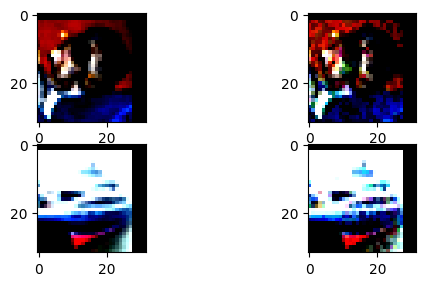

In [18]:
import torchattacks
from robustbench.data import load_cifar10
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

def init_model():

  model_ftex = models.resnet152(pretrained=True)
  modules=list(model_ftex.children())[:-2]
  print(list(model_ftex.children()))
  print(modules)
  print(len(modules))
  model_ftex=nn.Sequential(*modules).to(device)

  model_ftex.eval()



init_model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])

model = models.resnet152(pretrained=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

index = [0, 1]
images = torch.tensor([])
labels = []
for i in range(len(index)):
  img, label = testset[i]
  img = img.unsqueeze(0)
  images = torch.cat((images, img), dim=0)
  labels.append(label)

labels = torch.tensor(labels)


preprocess = transforms.Compose([
                # transforms.Resize((224,224)),
                transforms.RandomCrop(32, 4),
                normalize
            ])
images = preprocess(images)

attack = torchattacks.FGSM(model, eps=50/255)
img_adv = attack(images, labels)

i = 0
counter = 1
while i < len(index):
  plt.subplot(3, len(index), counter)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.subplot(3, len(index),counter + 1)
  plt.imshow(img_adv[i].permute(1, 2, 0))
  counter = counter + 2
  i = i + 1





(2, 2048)
(2, 2048)
   Principal Component 1  Principal Component 2  Label
0              10.724190              -9.176991      1
1              17.128668              -2.885987      1
0               3.844058              -8.637377      5
1               9.809924              -4.528239      5


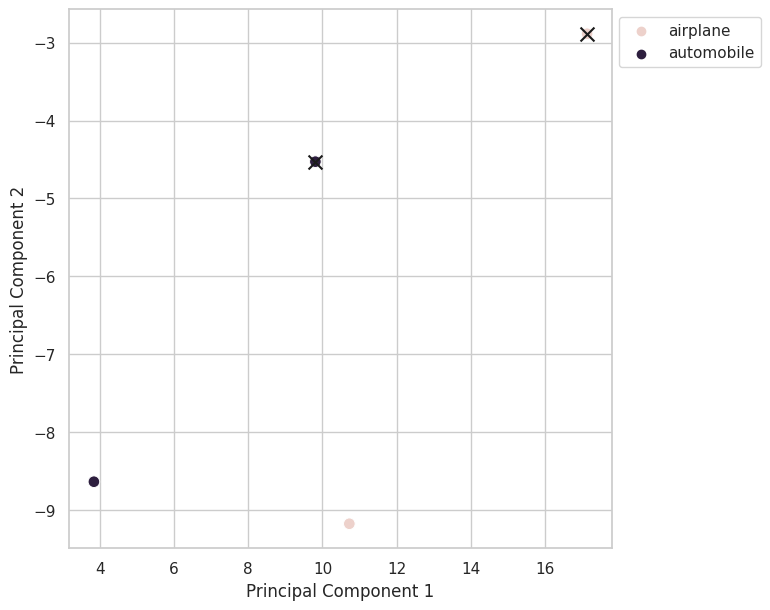

In [21]:
def compare(img, img_a, label):
  '''
  Returns a pandas dataframe with image features
  '''

  img, img_a = img.unsqueeze(0).to(device), img_a.unsqueeze(0).to(device)

  with torch.no_grad():
   output = model_ftex(img).to('cpu')
   output_a =  model_ftex(img_a).to('cpu')

  # flatten
  output = torch.flatten(output, start_dim=1)
  output_a = torch.flatten(output_a, start_dim=1)

  features = [output, output_a]
  features_np = [x.squeeze().numpy() for x in features]
  features_np = np.array(features_np)
  print(features_np.shape)

  labels = np.array([label, label])
  features = ['Feature' + str(i) for i in range(features_np.shape[1])]
  df_cifar = pd.DataFrame(features_np, columns = features)
  df_cifar['Label'] = labels
  # apply PCA to each column except the last one (label)
  convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
  df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
  df_converted_data['Label'] = labels

  # print(df_converted_data.head())
  return df_converted_data


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))



df_feat = pd.DataFrame()

for i in range(len(index)):
  df = compare(images[i], img_adv[i], labels[i]).copy()
  df_feat = pd.concat([df_feat, df])

print(df_feat.head())


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_feat, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                # palette=sns.color_palette("Spectral", as_cmap=True),
                s = 70)

plt.scatter(x=df_feat['Principal Component 1'][1] , y=df_feat['Principal Component 2'][1], color='k', marker="x", s=100)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')